In [1]:
# reload magics
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import log10

from project_modules.utils import get_logger
logger = get_logger("log-data-umap.log")
# read the parameter file

from project_modules.utils import read_parameters
parms = read_parameters("/Users/david/projects/lc-project-data/project.yaml")

[2024-04-05 14:42:19] [get_logger] Logger initialized.
[2024-04-05 14:42:19] [get_logger] Logging to file: log-data-umap.log
[2024-04-05 14:42:19] [read_parameters] Reading parameters.
[2024-04-05 14:42:19] [read_parameters] ... reading /Users/david/projects/lc-project-data/project.yaml


In [2]:
parms

{'project': 'lc',
 'dir_raw_data': '/Users/david/projects/lc-project-data/raw-data',
 'dir_proc_data': '/Users/david/projects/lc-project-data/processed-data',
 'dir_output': '/Users/david/projects/lc-project-data/output',
 'file_raw_data': 'specimen-data.xlsx'}

In [3]:
from pathlib import Path
input_dir = Path(parms["dir_proc_data"])
ipath = Path(input_dir / "SYNTHETIC_features")
ipath

PosixPath('/Users/david/projects/lc-project-data/processed-data/SYNTHETIC_features')

In [4]:
from project_modules.io import load_dataset_to_df
df = load_dataset_to_df(ipath, verbose = True)

from datasets import Dataset

labels = Dataset.load_from_disk(Path(parms['dir_proc_data']) / "SYNTHETIC_labels")

[2024-04-05 14:42:20] [load_dataset_to_df] Loading data from /Users/david/projects/lc-project-data/processed-data/SYNTHETIC_features...
[2024-04-05 14:42:20] [load_dataset_to_df] Converting to dataframe...
[2024-04-05 14:42:20] [load_dataset_to_df] Shape: (1000, 25)


In [5]:
# select all but the datetime64 types
df = df.select_dtypes(exclude=['datetime64', 'object'])

In [6]:
# split into train and test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# split into train and test
X = df
y = pd.DataFrame(labels['TRUE_LABEL'], columns=['TRUE_LABEL'])
X_train, X_test,\
     y_train, y_test = train_test_split(X, y, test_size=0.3)

# split the X_test into eval and holdout
X_eval, X_holdout,\
     y_eval, y_holdout = train_test_split(X_test, y_test, test_size=0.5)

In [7]:
X_train.shape, X_eval.shape, X_holdout.shape


((700, 25), (150, 25), (150, 25))

In [8]:
y_train.shape, y_eval.shape, y_holdout.shape

((700, 1), (150, 1), (150, 1))

In [9]:
import umap, hdbscan
um   = umap.UMAP(
                        metric       = 'euclidean', 
                        min_dist     = 0.1,  
                        # random_state = 42, 
                    )

# # use HDBSCAN to generate a cluster id
clusterer = hdbscan.HDBSCAN(
    min_cluster_size = 50,
    min_samples      = 10,
    cluster_selection_epsilon = 0.5,
    metric           = 'euclidean',
    prediction_data  = True,
)

# fit a dimensionality-reducer to the training data
um.fit(X_train)

# transform the training data
X_train_reduced = um.transform(X_train)

# fit the clusterer
clusterer.fit(X_train_reduced)

# assign the cluster id to the training data
X_train_reduced = pd.DataFrame(X_train_reduced, columns = ['UMAP1', 'UMAP2'])
X_train_reduced['CLUSTER_ID'] = clusterer.labels_

# reduce 

In [10]:
# now use the fitted reducer and fitted clusterer to predict the cluster id for the evaluation and holdout data

X_eval_reduced  = um.transform(X_eval)
X_holdout_reduced  = um.transform(X_holdout)

eval_clusters = hdbscan.approximate_predict(clusterer, X_eval_reduced)
holdout_clusters = hdbscan.approximate_predict(clusterer, X_holdout_reduced)

Xer = pd.DataFrame(X_eval_reduced, columns = ['UMAP1', 'UMAP2'])
Xer['CLUSTER_ID'] = hdbscan.approximate_predict(clusterer, X_eval_reduced)[0]

Xhr = pd.DataFrame(X_holdout_reduced, columns = ['UMAP1', 'UMAP2'])
Xhr['CLUSTER_ID'] = hdbscan.approximate_predict(clusterer, X_holdout_reduced)[0]


Text(0.5, 1.0, 'UMAP of Synthetic Data')

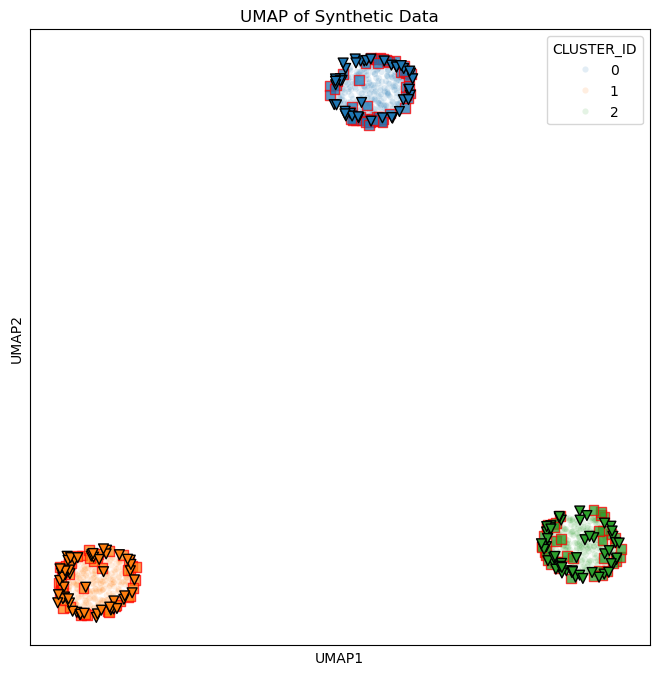

In [11]:
# plot the umap coordinates
plt.figure(figsize=(8,8))

# the data used to train the reducer and clusterer
sns.scatterplot(data = X_train_reduced, x='UMAP1', y='UMAP2', legend = True, hue = 'CLUSTER_ID', palette = "tab10", alpha = 0.125, marker = "o", s = 20)

# eval
sns.scatterplot(data = Xer, x='UMAP1', y='UMAP2', legend = False, hue = 'CLUSTER_ID', palette = "tab10", alpha = 0.75, marker = "s", s = 50, edgecolor = 'r', linewidth = 1.0, label = "Eval")

# holdout
sns.scatterplot(data = Xhr, x='UMAP1', y='UMAP2', legend = False, hue = 'CLUSTER_ID', palette = "tab10", alpha = 1.0, marker = "v", s = 50, edgecolor = 'k', linewidth = 1.0, label = "Holdout")


# turn off ticks
plt.tick_params(
    axis='both',          # changes apply to the x-axis and y-axis
    which='both',         # both major and minor ticks are affected
    bottom=False,         # ticks along the bottom edge are off
    left=False,           # ticks along the top edge are off
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off


plt.title("UMAP of Synthetic Data")

In [12]:
# train an rfc to predict cluster using just reduced dims as features
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

ftrs = ['UMAP1', 'UMAP2']

# split the data
# X_train, X_test= train_test_split(X_train_reduced,test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train_reduced[ftrs], clusterer.labels_, test_size=0.33, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_train_reduced, cluster_id, test_size=0.33, random_state=42)

# train the model
rfc = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
rfc.fit(X_train[ftrs], y_train)

# predict the test data
y_pred = rfc.predict(X_test[ftrs])
y_proba = rfc.predict_proba(X_test[ftrs])

# get the accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)


1.0

In [13]:
X_train

,UMAP1,UMAP2
137,-4.782524,-3.073091
486,5.115473,15.813763
571,6.075985,17.838840
33,-3.414311,-3.925384
588,-3.988738,-4.774766
...,...,...
71,13.035832,-1.345727
106,13.469810,-2.380536
270,5.538146,17.187357
435,-4.346424,-3.535658


In [14]:
pd.DataFrame(y_proba).describe()

,0,1,2
count,231.000000,231.000000,231.000000
mean,0.324675,0.347649,0.327675
std,0.469270,0.449701,0.442400
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.020573,0.016371
75%,1.000000,0.941975,0.979427
max,1.000000,0.983629,0.979427


<Axes: xlabel='UMAP1', ylabel='UMAP2'>

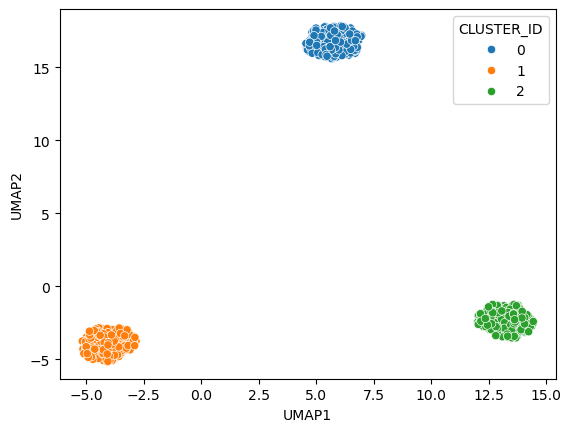

In [15]:
sns.scatterplot(data = X_train_reduced, x='UMAP1', y='UMAP2', legend = True, hue = 'CLUSTER_ID', palette = "tab10", marker = "o")

In [16]:
import joblib

# save the model
joblib.dump(rfc, "rfc.joblib")
# joblib.dump(coords, "umap.joblib")
foo = joblib.load("rfc.joblib")